In [1]:
import platform
import sys
import os
import os.path as osp
import datetime
import logging
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import traceback

print(platform.python_version())
print(sys.version)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from keras.optimizers import Adam
from keras_radam import RAdam
from keras.layers.advanced_activations import ReLU
from keras_contrib.layers.advanced_activations.swish import Swish
from keras import backend as K
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.wrappers.scikit_learn import KerasClassifier
from keras.losses import categorical_crossentropy
from keras.utils import Sequence,to_categorical, plot_model
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
from tqdm import tqdm, tqdm_notebook
from keras_tqdm import TQDMNotebookCallback

###################################
#Clean session
sess = get_session()
clear_session()
sess.close()
# TensorFlow wizardry
config = tf.ConfigProto(log_device_placement=True)

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################

# Magic used by the notebook to show figures inline

%matplotlib inline
# matplotlib default values
plt.rcParams["figure.figsize"] = (20.0, 16.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "jet"

# auto-reloading packages
%load_ext autoreload
%autoreload 2

# local package
from mmciad.utils.io import read_samples, load_slides, load_slides_as_dict
from mmciad.utils.u_net import u_net
#from mmciad.utils.u_resnet import u_resnet
from mmciad.utils.custom_loss import weighted_loss, jaccard2_loss, tversky_loss, categorical_focal_loss, get_weighted_categorical_crossentropy
from mmciad.utils.preprocessing import calculate_stats, calculate_class_weights
from mmciad.utils.callbacks import PatchedModelCheckpoint

3.6.8
3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


Using TensorFlow backend.


In [2]:
from skimage.io import imread, imsave
from glob import glob

data_path = "./data/ADEChallengeData2016/"
img_path = "images"
annot_path = "annotations"
train_path = "training/"
val_path = "validation/"
num_class=151
np.random.seed(1992)

In [20]:
def batch(iterable, n=1):
    l = len(iterable)
    counter = 0
    for ndx in range(0, l, n):
        counter += 1
        yield counter, iterable[ndx:min(ndx + n, l)]

def create_samples(path, prefix="training"):
    size = (208, 208)
    X_files = sorted(glob(osp.join(path, img_path, prefix, "*.jpg")), key=str.lower)
    Y_files = sorted(glob(osp.join(path, annot_path, prefix, "*.png")), key=str.lower)
    XY_files = list(zip(X_files, Y_files))
    num_img = len(X_files)
    print(num_img)
    Xr = []  # np.zeros(shape=(n_samples*num_img, size[0], size[1], 3), dtype="float")
    Yr = []  # np.zeros(shape=(n_samples*num_img, size[0], size[1], num_cls), dtype="uint8")
    output_img_counter = 0
    for count, XY_batch in batch(XY_files, 50):
        X_batch = [i[0] for i in XY_batch]
        Y_batch = [i[1] for i in XY_batch]
        X_samples = [imread(i).astype("float") / 255.0 for i in X_batch]
        for idx in range(len(X_samples)):
            if len(X_samples[idx].shape) != 3:
                X_samples[idx] = np.stack((X_samples[idx],)*3, axis=-1)
        Y_samples = [imread(i) for i in Y_batch]
        for x_i, y_i in zip(X_samples, Y_samples):
            X_, Y_ = y_i.shape
            px, py = np.mgrid[0:X_:160, 0:Y_:160]
            points = np.c_[px.ravel(), py.ravel()]
            pr = points.shape[0]
            for n in range(pr):
                x, y = points[n, :]
                res_x = x_i[x : x + size[0], y : y + size[1]]
                res_y = y_i[x : x + size[0], y : y + size[1]]
                change = False
                keep = True
                if X_ < 208 or Y_ < 208:
                    keep = False
                if (x + size[0]) > X_:
                    x = X_ - size[0]
                    change = True
                if (y + size[1]) > Y_:
                    y = Y_ - size[1]
                    change = True
                if change:
                    res_x = x_i[x : x + size[0], y : y + size[1]]
                    res_y = y_i[x : x + size[0], y : y + size[1]]
                if keep:
                    Xr.append(res_x)
                    Yr.append(res_y)
        #X = np.vstack(Xr).astype("float")
        #Y = np.vstack(Yr).astype("uint8")
        for i in range(len(Xr)):  ## Check_contrast will be available from version 0.15
            imsave(osp.join(path, img_path, prefix, "X_{:08d}.tif".format(output_img_counter)), Xr[i].astype("float"), check_contrast=False)
            imsave(osp.join(path, img_path, prefix, "gt","X_{:08d}.tif".format(output_img_counter)), Yr[i].astype("uint8"), check_contrast=False)
            output_img_counter += 1
        del Xr[:]  # np.zeros(shape=(n_samples*num_img, size[0], size[1], 3), dtype="float")
        del Yr[:]  # np.zeros(shape=(n_samples*num_img, size[0], size[1], num_cls), dtype="uint8")
    print("{} image from {} data created.".format(output_img_counter, prefix))

create_samples(data_path, train_path)
create_samples(data_path,val_path)

20210


TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
#train_m, train_s, x_min, x_max = calculate_stats(path=data_path, local=False)

In [24]:
from imgaug import augmenters as iaa
def augmentor(img, segmap):
    seq = iaa.SomeOf((0, None), [
        iaa.Fliplr(1),
        #iaa.Affine(rotate=(-45, 45), mode="reflect"),
        iaa.Affine(scale=(0.9, 1.2), mode="reflect"),
    ])
    seq_det = seq.to_deterministic()
    img_aug = seq_det.augment_images(img)
    segmap_aug = seq_det.augment_images(segmap)
    return img_aug, segmap_aug

class DataGenerator(Sequence):
    "Generates data for Keras"

    def __init__(
        self,
        path,
        #colorvec,
        #means,
        #stds,
        #x_min,
        #x_max,
        list_IDs=None,
        batch_size=32,
        dim=(208, 208),
        n_channels=3,
        n_classes=10,
        shuffle=True,
        augmenter=True,
    ):
        "Initialization"
        self.dim = dim
        self.path = path
        #self.colorvec = colorvec
        #self.means = means
        #self.stds = stds
        #self.x_min = x_min
        #self.x_max = x_max
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augmenter

        if self.list_IDs is None:
            self.list_IDs = [
                osp.splitext(osp.basename(i))[0]
                for i in glob(osp.join(self.path, "*.tif"))
            ]

        self.on_epoch_end()

    def __len__(self):
        "Denotes the number of batches per epoch"
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        "Generate one batch of data"
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        "Updates indexes after each epoch"
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        "Generates data containing batch_size samples"
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1), dtype=np.uint8)
        y_class = [
            np.zeros((*self.dim, 1), dtype=np.uint8) for _ in range(self.batch_size)
        ]

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            try:
                X[i] = imread(self.path + ID + ".tif").astype("float")
            except ValueError:
                x_tmp = imread(self.path + ID + ".tif").astype("float")
                assert len(x_tmp.shape) == 2, "Something else is wrong"
                X[i] = np.stack((x_tmp,)*3, axis=-1)
            #X[i] = (X[i] - self.means) / self.stds
            #X[i] = (X[i] - self.x_min)/(self.x_max - self.x_min)
            # Store class
            y[i,] = np.expand_dims(imread(self.path + "gt/" + ID + ".tif").astype("uint8"), axis=-1)
            #for cls_ in range(self.n_classes):
            #    color = self.colorvec[cls_, :]
            #    y_class[i] += np.expand_dims(
            #        np.logical_and.reduce(y[i,] == color, axis=-1) * cls_, axis=-1
            #    ).astype("uint8")
            y_class[i] = to_categorical(y[i], num_classes=self.n_classes)
        if self.augment:
            X, y = augmentor(X, y_class)

        return np.asarray(X, dtype="float"), np.asarray(y, dtype="uint8")

In [25]:
# I/O Params
weight_path = "./weights"

IMG_ROWS, IMG_COLS, IMG_CHANNELS = (None, None, 3)
# architecture params
NB_FILTERS_0 = 64
SIGMA_NOISE = 0.01

# ****  deep learning model
SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)
BATCH_SIZE = 12
NB_EPOCH = 400
NB_FROZEN = 40
VERBOSE = 0

train_generator = DataGenerator(
    osp.join(data_path, img_path, train_path),
    batch_size=BATCH_SIZE,
    dim=(208, 208),
    n_channels=3,
    n_classes=num_class,
    shuffle=True,
    augmenter=True,
)

val_generator = DataGenerator(
    osp.join(data_path, img_path, val_path),
    batch_size=BATCH_SIZE,
    dim=(208, 208),
    n_channels=3,
    n_classes=num_class,
    shuffle=True,
    augmenter=True,
)

In [26]:
###################################
#Clean session
sess = get_session()
clear_session()
sess.close()
# TensorFlow wizardry
config = tf.ConfigProto(log_device_placement=True)

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################
RUN_DATE = "2019-10-17"
modelpath = osp.join(
    weight_path, RUN_DATE,"pretrain_U-net_model.h5"
)
log_path = osp.join(
    "./logs",
    RUN_DATE,
    "pretrain_U-net",
    ''
)
model_kwargs = {
    "shape": SHAPE,
    "nb_filters": NB_FILTERS_0,
    "sigma_noise": SIGMA_NOISE,
    "depth": 4,
    "maxpool": False,
    "initialization": "he_normal",
    "activation": Swish,
    "dropout": 0,
    "output_channels": 151,
    "batchnorm": True,
    "pretrain": 0,
    "arch": "U-Net",
}

#if not os.path.exists(modelpath):
#    os.makedirs(modelpath, exist_ok=True)

csv_logger = CSVLogger("pretraincsvlog.csv", append=True)
tqdm_progress = TQDMNotebookCallback(
    metric_format="{name}: {value:0.4f}", leave_inner=True, leave_outer=True
)
tb_callback = TensorBoard(
    log_dir=log_path,
    histogram_freq=0,
    batch_size=BATCH_SIZE,
    write_graph=True,
    write_grads=False,
    write_images=True,
    embeddings_freq=0,
    update_freq="epoch",
)
early_stopping = EarlyStopping(
    monitor="loss", min_delta=0.0001, patience=15, verbose=0, mode="auto"
)
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor="loss", factor=0.1, patience=5, min_lr=1e-8, verbose=1
)
model_checkpoint = PatchedModelCheckpoint(
    modelpath, verbose=0, monitor="loss", save_best_only=True
)

model_callbacks = [csv_logger, tb_callback, tqdm_progress]
opti_callbacks = [early_stopping, reduce_lr_on_plateau, model_checkpoint]
model = u_net(**model_kwargs)
model.compile(
    loss=categorical_crossentropy,
    optimizer=Adam(1e-4),
    metrics=["acc"],
    # weighted_metrics=["acc"],
)

history = model.fit_generator(
    generator=train_generator,
    epochs=NB_EPOCH,
    validation_data=val_generator,
    use_multiprocessing=True,
    workers=30,
    verbose=VERBOSE,
    callbacks=model_callbacks + opti_callbacks,
)

Process ForkPoolWorker-746:
Process ForkPoolWorker-758:
Process ForkPoolWorker-759:
Process ForkPoolWorker-766:
Process ForkPoolWorker-733:
Process ForkPoolWorker-744:
Process ForkPoolWorker-726:
Process ForkPoolWorker-727:
Process ForkPoolWorker-780:
Process ForkPoolWorker-770:
Process ForkPoolWorker-763:
Process ForkPoolWorker-768:
Process ForkPoolWorker-753:
Process ForkPoolWorker-730:
Process ForkPoolWorker-764:
Process ForkPoolWorker-777:
Process ForkPoolWorker-761:
Process ForkPoolWorker-756:
Process ForkPoolWorker-734:
Process ForkPoolWorker-747:
Process ForkPoolWorker-743:
Process ForkPoolWorker-749:
Process ForkPoolWorker-781:
Process ForkPoolWorker-757:
Process ForkPoolWorker-772:
Process ForkPoolWorker-755:
Process ForkPoolWorker-740:
Process ForkPoolWorker-762:
Process ForkPoolWorker-750:
Process ForkPoolWorker-751:
Process ForkPoolWorker-760:
Process ForkPoolWorker-739:
Process ForkPoolWorker-748:
Process ForkPoolWorker-754:
Process ForkPoolWorker-738:
Process ForkPoolWork

KeyboardInterrupt: 

  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "<ipython-input-24-4499c21f8be6>", line 108, in __data_generation
    X, y = augmentor(X, y_class)
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/imgaug/augmenters/meta.py", line 3118, in _augment_images
    hooks=hooks
  File "<ipython-input-24-4499c21f8be6>", line 10, in augmentor
    segmap_aug = seq_det.augment_images(segmap)
  File "<ipython-input-24-4499c21f8be6>", line 68, in __getitem__
    X, y = self.__data_generation(list_IDs_temp)
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/imgaug/augmenters/meta.py", line 515, in augment_images
    hooks=hooks
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/site-packages/imgaug/augmenters/meta.py", line 603, in augment_imag

In [32]:
#model.save_weights(modelpath)
history = model.fit_generator(
    generator=train_generator,
    epochs=NB_EPOCH,
    initial_epoch=7,
    validation_data=val_generator,
    use_multiprocessing=True,
    workers=30,
    verbose=VERBOSE,
    callbacks=model_callbacks + opti_callbacks,
)

Process ForkPoolWorker-1135:
Process ForkPoolWorker-1117:
Process ForkPoolWorker-1140:
Process ForkPoolWorker-1100:
Process ForkPoolWorker-1091:
Process ForkPoolWorker-1124:
Process ForkPoolWorker-1093:
Process ForkPoolWorker-1110:
Process ForkPoolWorker-1083:
Process ForkPoolWorker-1129:
Process ForkPoolWorker-1125:
Process ForkPoolWorker-1126:
Process ForkPoolWorker-1121:
Process ForkPoolWorker-1127:
Process ForkPoolWorker-1115:
Process ForkPoolWorker-1098:
Process ForkPoolWorker-1085:
Process ForkPoolWorker-1128:
Process ForkPoolWorker-1138:
Process ForkPoolWorker-1133:
Process ForkPoolWorker-1139:
Process ForkPoolWorker-1136:
Process ForkPoolWorker-1122:
Process ForkPoolWorker-1134:
Process ForkPoolWorker-1119:
Process ForkPoolWorker-1095:
Process ForkPoolWorker-1112:
Process ForkPoolWorker-1123:
Process ForkPoolWorker-1116:
Process ForkPoolWorker-1132:
Process ForkPoolWorker-1131:
Process ForkPoolWorker-1120:
Process ForkPoolWorker-1103:
Process ForkPoolWorker-1118:
Process ForkPo

KeyboardInterrupt: 

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "<ipython-input-24-4499c21f8be6>", line 108, in __data_generation
    X, y = augmentor(X, y_class)
  File "<ipython-input-24-4499c21f8be6>", line 108, in __data_generation
    X, y = augmentor(X, y_class)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "<ipython-input-24-4499c21f8be6>", line 10, in augmentor
    segmap_aug = seq_det.augment_images(segmap)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/bjarne/.pyenv/versions/miniconda3-4.3.30/envs/tf_gpu/lib/python3.6/multiprocessing/connection.py",

In [35]:
import os, re

def purge(dir, pattern):
    for f in os.listdir(dir):
        if re.search(pattern, f):
            os.remove(os.path.join(dir, f))

#purge(osp.join(data_path, img_path, train_path), "^X_[0-9]{7}[13579].tif$")
#purge(osp.join(data_path, img_path, train_path, "gt"), "^X_[0-9]{7}[13579].tif$")
#purge(osp.join(data_path, img_path, val_path), "^X_[0-9]{7}[13579].tif$")
#purge(osp.join(data_path, img_path, val_path, "gt"), "^X_[0-9]{7}[13579].tif$")

train_generator = DataGenerator(
    osp.join(data_path, img_path, train_path),
    batch_size=BATCH_SIZE,
    dim=(208, 208),
    n_channels=3,
    n_classes=num_class,
    shuffle=True,
    augmenter=True,
)

val_generator = DataGenerator(
    osp.join(data_path, img_path, val_path),
    batch_size=BATCH_SIZE,
    dim=(208, 208),
    n_channels=3,
    n_classes=num_class,
    shuffle=True,
    augmenter=True,
)

history = model.fit_generator(
    generator=train_generator,
    epochs=100,
    initial_epoch=11,
    validation_data=val_generator,
    use_multiprocessing=True,
    workers=30,
    verbose=VERBOSE,
    callbacks=model_callbacks + opti_callbacks,
)

Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


Error while trying to save the model: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable').
Trying again...


(340, 449, 3)

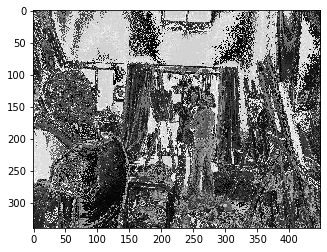

In [19]:
a = imread("./data/ADEChallengeData2016/images/training/ADE_train_00001701.jpg")
plt.imshow(a, cmap="gray")
a.shape
b = np.stack((a,)*3, axis=-1)
b.shape

In [15]:
files = sorted(glob(osp.join(data_path, img_path, train_path, "*.jpg")), key=str.lower)

for file in files:
    img = imread(file)
    if len(img.shape) != 3:
        print("path: {}".format(file))
        print("actual shape: {}".format(img.shape))
print("Done!")

path: ./data/ADEChallengeData2016/images/training/ADE_train_00001701.jpg
actual shape: (340, 449)
path: ./data/ADEChallengeData2016/images/training/ADE_train_00003020.jpg
actual shape: (216, 216)
path: ./data/ADEChallengeData2016/images/training/ADE_train_00008455.jpg
actual shape: (512, 686)
path: ./data/ADEChallengeData2016/images/training/ADE_train_00013508.jpg
actual shape: (455, 700)
Done!


In [30]:
model.history.history

{'val_loss': [2.0383654946270706,
  1.8595609805635318,
  1.70548054490312,
  1.6416993811325282,
  1.581998532400525,
  1.5785167608109154,
  1.5798824719777014],
 'val_acc': [0.4746045197629415,
  0.5117727090843704,
  0.5444471126077847,
  0.5556073971962159,
  0.5708089579612391,
  0.5692585475167637,
  0.5686792852206547],
 'loss': [2.5305749942465816,
  2.005576080798182,
  1.8037207607087917,
  1.6707491717771272,
  1.5694327293190689,
  1.4892524225390797,
  1.4185654278657072],
 'acc': [0.39428879182543597,
  0.4821443026652913,
  0.5239765376163582,
  0.5516891845921147,
  0.5727867747221203,
  0.5896382626542189,
  0.6050836267249039]}

In [37]:
model.evaluate_generator(val_generator)

[2.0861957075886925, 0.572938495146736]

In [66]:
def get_list_IDs(path):
    list_IDs = [
        osp.splitext(osp.basename(i))[0]
        for i in glob(osp.join(path, "*.tif"))
    ]
    indexes = np.arange(len(list_IDs))
    return list_IDs, indexes

def create_test_pair(list_IDs, indexes, path):
    list_IDs_temp = [list_IDs[k] for k in indexes]
    
    input_img, target_img = generate_pair(list_IDs_temp, path)
    return input_img, target_img

def generate_pair(list_IDs_temp, path):
    ID = list_IDs_temp[0]
    input_img = imread(path + ID + ".tif").astype("float")
    target_img = imread(path + "gt/" + ID + ".tif").astype("uint8")
    target_img = to_categorical(target_img, num_classes=151)
    return input_img, target_img

training_path = osp.join(data_path,img_path, train_path)
predict_path = osp.join(data_path,img_path, val_path)
print(predict_path)
list_IDs, indexes = get_list_IDs(training_path)

./data/ADEChallengeData2016/images/validation/


Text(0.5, 1.0, 'predicted image')

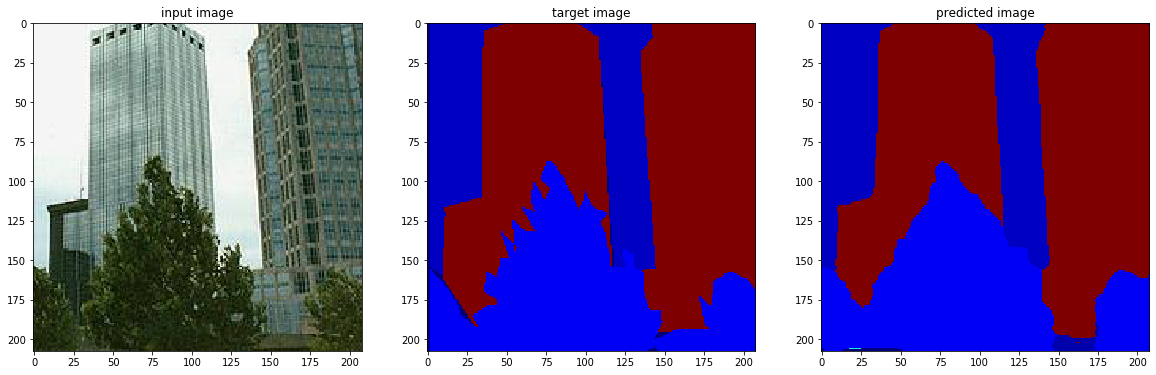

In [76]:
np.random.shuffle(indexes)
input_img, target_img = create_test_pair(list_IDs, indexes, training_path)
predict_img = model.predict(np.expand_dims(input_img, axis=0))
predict_img = np.squeeze(predict_img)
plt.rcParams["figure.figsize"] = (20.0, 16.0)
plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title("input image")
plt.subplot(1, 3, 2)
plt.imshow(np.argmax(target_img, axis =-1))
plt.title("target image")
plt.subplot(1, 3, 3)
plt.imshow(np.argmax(predict_img, axis =-1))
plt.title("predicted image")

In [54]:
plt.savefig("ADE_example2.png")

<Figure size 1440x1152 with 0 Axes>